<a href="https://colab.research.google.com/github/hariszaf/metabolic_toy_model/blob/main/Antony2025/computationalMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computational Methods Applied To Genome-Scale Metabolic Models**

### **Prepare your environment**

To run this note, you need COBRApy and gurobi. [See the notebook on preparing your environment for a more detailed explanation](preparingYourEnvironment.ipynb)

In [1]:
# @title
import os
def create_gurobi_license():
    license_content = (
        "# Gurobi WLS license file\n"
        "# Your credentials are private and should not be shared or copied to public repositories.\n"
        "# Visit https://license.gurobi.com/manager/doc/overview for more information.\n"
        "WLSACCESSID=1fedf73b-9471-4da8-bdc7-2aaacf2e30f3\n"
        "WLSSECRET=3bc7d209-a4ec-4195-98be-4b254f181512\n"
        "LICENSEID=940603"
    )
    with open("/content/licenses/gurobi.lic", "w") as f:
        f.write(license_content)
    print("License file created at /content/licenses/gurobi.lic")



# Create directory for the license
os.makedirs("/content/licenses", exist_ok=True)

# Generate the license file
create_gurobi_license()

#add to path
os.environ['GRB_LICENSE_FILE'] = '/content/licenses/gurobi.lic'

License file created at /content/licenses/gurobi.lic


In [2]:
# @title

!pip install gurobipy
!pip install cobra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 29.2 MB/s eta 0:00:00


In [5]:
# @title
import gurobipy
from gurobipy import Model
model = Model("test")
print("Gurobi is working!", "\U0001F600")

#install COBRApy
import cobra
from cobra.io import load_model
model = load_model("textbook")
solution = model.optimize()
print(f"flux balance analysis solution is {solution.objective_value}")
print("COBRApy is working", "\U0001F600")

Gurobi is working! 😀
flux balance analysis solution is 0.8739215069684305
COBRApy is working 😀


#### **Get path with files we will use**

In [6]:
!git clone https://github.com/hariszaf/metabolic_toy_model.git
files_path = "metabolic_toy_model/Antony2025/files"

Cloning into 'metabolic_toy_model'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 509 (delta 70), reused 44 (delta 13), pack-reused 385 (from 1)
Receiving objects: 100% (509/509), 58.06 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (258/258), done.
Updating files: 100% (146/146), done.


### **MAMBO**

![MAMBO](https://github.com/hariszaf/metabolic_toy_model/blob/main/Antony2025/images/garza2018.png?raw=1)

#### **Get our models**

In [7]:
sugar_fermenter = cobra.io.read_sbml_model(files_path + "/models/sugar_fermenter_toy_model.xml")
butyrate_producer = cobra.io.read_sbml_model(files_path + "/models/butyrate_producer_toy_model.xml")
acetogen = cobra.io.read_sbml_model(files_path + "/models/acetogen_toy_model.xml")

#### **Get the code for MAMBO**

In [30]:
import numpy as np
import scipy.stats as sts

def apply_environment(mdl, media_dict):
    for i in media_dict:
        if mdl.reactions.has_id(i):
            mdl.reactions.get_by_id(i).lower_bound=-media_dict[i]

    sol_m=mdl.optimize()
    return sol_m.objective_value

def getRMSE(x,y):

    return np.sqrt( np.mean( (x-y)**2) )

def MetropolisSA(new_value, current_value, rabs, T):

    if None in new_value:
        return (False, 0, 0, 1)

    candidate_prob = np.exp(-getRMSE(current_value, new_value) / T)


    if np.random.uniform() < candidate_prob:
        return (True, candidate_prob) #True means the statistics will be accepted.
    else:
        return (False, candidate_prob)#Statistics rejected.


def Metropolis(new_value, current_value, rabs):

    if None in new_value:
        return (False, 0, 0, 1)
    optimal = np.arcsinh(0.999)
    standard_error = 0.45#(1/(len(new_value)**0.5))
    candidate_prob = sts.norm.pdf(np.arctanh(sts.pearsonr(new_value, rabs)[0]), loc=optimal,scale=standard_error)

    current_prob = sts.norm.pdf(np.arctanh(sts.pearsonr(current_value, rabs)[0]), loc=optimal,scale=standard_error)

    statistic = candidate_prob/current_prob

    if np.random.uniform() < statistic:
        return (True, statistic, candidate_prob, current_prob) #True means the statistics will be accepted.
    else:
        return (False, statistic, candidate_prob, current_prob)#Statistics rejected.


def current_solution(modelList, media):
    sol = np.array([apply_environment(i, media) for i in modelList])
    return sol


def MCMC(media, modelList, rab):
    m2 = media.copy()
    ch = np.random.choice(list(media))
    m2[ch]= max(0, m2[ch] + np.random.uniform(low=-0.5, high=0.5))
    sol_current = current_solution(modelList, media)
    sol_candidate = current_solution(modelList, m2)

    met = Metropolis(sol_candidate, sol_current, rab)


    print(met)

    if met[0]:
        return (sol_candidate, m2)

    else:
        return (sol_current, media)

def bunching(vec):
    p0 = vec[0]

    for i in range(1, len(vec)):
        p0 = (p0 + vec[i])/2

    return p0






#### **Run MAMBO**

In [37]:
media = {'EX_cpd00027_e':1,
         'EX_cpd00011_e':1,
         'EX_cpd11640_e':1,
         'EX_cpd00159_e':1,
         'EX_cpd00047_e':1,
         'EX_cpd00029_e':1
         }
apply_environment(acetogen, media)
apply_environment(sugar_fermenter, media)
apply_environment(butyrate_producer, media)


acetogen.optimize()
sugar_fermenter.optimize()
butyrate_producer.optimize()


modelList = [sugar_fermenter, butyrate_producer, acetogen]

#####Composition Vector####
composition = np.array([9, 10, 8])

medias = [np.array(list(media.values()))]
solutions = [current_solution(modelList, media)]

for i in range(1000):#should be much larger

    print(i)
    solution, media = MCMC(media, modelList, composition)

    if (i>10):#should be much larger

        medias.append(np.array(list(media.values())))
        solutions.append(solution)

0
(True, 1.0, 0.4212127706944501, 0.4212127706944501)
1
(True, 2.0327765336233043, 0.8562314359301321, 0.4212127706944501)
2
(False, 0.1007060706895485, 0.0862277035133935, 0.8562314359301321)
3
(False, 0.2673439228159148, 0.22890827091986513, 0.8562314359301321)
4
(False, 1.752310241926453e-24, 1.5003831146397641e-24, 0.8562314359301321)
5
(True, 1.0, 0.8562314359301321, 0.8562314359301321)
6
(True, 1.0, 0.8562314359301321, 0.8562314359301321)
7
(True, 1.0112816561154472, 0.8658911445455313, 0.8562314359301321)
8
(True, 1.0, 0.8658911445455313, 0.8658911445455313)
9
(True, 0.9074215074846452, 0.7857282477011108, 0.8658911445455313)
10
(True, 1.0, 0.7857282477011108, 0.7857282477011108)
11
(True, 0.9996704999796383, 0.7854693502274945, 0.7857282477011108)
12
(False, 0.02003085423862848, 0.015733622063317167, 0.7854693502274945)
13
(True, 0.9755637918416239, 0.7662754576833111, 0.7854693502274945)
14
(True, 0.6575023943542567, 0.503827948161681, 0.7662754576833111)
15
(True, 1.0, 0.5038

#### **Get Correlations**

In [38]:
medias= np.array(medias)
mediasM = medias.copy()

medias= medias.T

maxMedias = np.max(mediasM, axis=1)
mediasM = np.array([mediasM[i]/maxMedias[i] for i in range(len(maxMedias))]).T

mSols = solutions.copy()
solutions = np.array(solutions).T
maxSolutions = np.max(mSols, axis=1)
mSols = np.array([mSols[i]/maxSolutions[i] for i in range(len(maxSolutions))]).T


cor = np.array([sts.pearsonr(i, composition)[0] for i in solutions.T])

print(cor)


[ 0.32002175  0.80124362  0.80124362  0.80883543  0.38189113  0.38189113
  0.54247056  0.54247056  0.54247056  0.72527327  0.72527327  0.72527327
  0.72527327  0.72527327  0.73344157  0.89105574  0.89105574  0.89105574
  0.89105574  0.89105574  0.58625563  0.58625563  0.58625563  0.58625563
  0.45433697  0.45433697  0.26044076  0.26044076  0.26044076  0.26044076
  0.26044076  0.26044076  0.32276685  0.36100291  0.36100291  0.36100291
  0.36100291  0.38985288  0.38985288  0.38985288  0.12035598  0.06607728
 -0.14011977  0.07454558 -0.03195975  0.35555544  0.63607978  0.63607978
  0.91138808  0.90500454  0.90500454  0.90500454  0.90500454  0.90500454
  0.90500454  0.90500454  0.41420849  0.41420849  0.41420849  0.82629138
  0.82779     0.82779     0.76969698  0.76969698  0.76969698  0.81409728
  0.81409728 -0.24767859 -0.24767859 -0.24767859 -0.24767859 -0.24767859
  0.11749665  0.88068794  0.88068794  0.79758521  0.8028811   0.8028811
  0.86617545  0.86617545  0.86613347  0.86613347  0.

#### **Select the final medium**

In [39]:

avM = np.median(medias.T[cor>0.90], axis=0)
avM = (avM/max(avM))*10
m = {list(media.keys())[i]: avM[i] for i in range(len(avM))}

print(f"composition was {composition} \t MAMBO solution was: {current_solution(modelList, m)}")

GurobiError: Overage for too long, 3 active sessions and over the baseline for 32 minutes

### **Dynamic flux balance analysis**

#### Task:

- Study the code below to understand how one can make FBA dynamic

- Make modifications to explore the three conditions (rich media, only glucose, and no glucose)

- Perform parameter sweeps to understand the effects of each class of parameters (e.g. yield, monod constants)

- How is the community different in a batch compared to when there is a flow-rate? How is the community impacted by the flow-rate?

- How is the community different when one removes the diauxic shift (in the growth rate function of the butyrate producer)?

- How is the H2/CO2 cross-feeding impacted by the yield and Monod constants?


#### **Import packages needed for ODE solving and visualization**

In [8]:
import numpy as np
from scipy.integrate import solve_ivp as solver
import matplotlib.pyplot as plt
#print(plt.style.available)
plt.style.use('seaborn-v0_8-bright')

import ipywidgets as widgets
from IPython.display import display
from collections import defaultdict
import functools

#### **Define parameters and initial states**

**Parameters**

| parameter | variable | default value |
| --------- | -------- | ------------- |
| acetogen glucose Monod K | ac_glucose_k | 1.0 |
| acetogen glucose yield | ac_glucose_y | 1.0 |
| acetogen formate Monod K | ac_for_k | 10.0 |
| acetogen formate yield | ac_for_y | 1.0 |
| acetogen CO2 Monod K | ac_co2_k | 1.0 |
| acetogen CO2 yield | ac_co2_y | 10.0 |
| acetogen H2 Monod K | ac_h2_k | 10.0 |
| acetogen H2 yield | ac_h2_y | 10.0 |
| acetogen acetate yield | ac_ac_y | -1.0 |
| acetogen lactate yield | ac_lac_y | -1.0 |
| sugarF glucose Monod K | sf_glucose_k | 1.0 |
| sugarF glucose yield | sf_glucose_y | 1.0 |
| sugarF succinate yield | sf_succ_y | -1.0 |
| sugarF formate yield | sf_for_y | -1.0 |
| sugarF lactate yield | sf_lac_y | -1.0 |
| sugarF acetate yield | sf_ac_y | -1.0 |
| butyrateP glucose Monod K | bp_glucose_k | 1.0 |
| butyrateP glucose yield | bp_glucose_y | 1.0 |
| butyrateP lactate consumpation Monod K | bp_lactate_c_k | 1.0 |
| butyrateP lactate consumption yield | bp_lactate_c_y | 1.0 |
| butyrateP lactate production yield | bp_lactate_p_y | -1.0 |
| butyrateP acetate consumpation Monod K | bp_acetate_c_k | 1.0 |
| butyrateP acetate consumption yield | bp_acetate_c_y | 1.0 |
| butyrateP acetate production yield | bp_acetate_p_y | -1.0 |
| butyrateP CO2 production yield | bp_co2_y | -1.0 |
| butyrateP H2 production yield | bp_h2_y | -1.0 |
| butyrateP butyrate production yield | bp_butyrate_y | -1.0 |
| flow rate | flow_rate | 0.1 |


**States**

| state | position | default value |
| ----- | -------- | ------------- |
|glucose concentration | 0 | 10 |
|formate concentration | 1 | 0 |
|CO2 concentration | 2 | 0 |
|H2 concentration | 3 | 0 |
|acetate concentration | 4 | 0 |
|lactate concentration | 5 | 0 |
|succinate concentration | 6 | 0 |
|butyrate concentration | 7 | 0 |
|acetogen biomass | 8 | 0.1 |
|sugarF biomass | 9 | 0.1 |
|butyrateP biomass | 10 | 0.1 |

In [9]:
# Parameters dictionary
parameters = {'ac_glucose_k' : 1.0,
              'ac_glucose_y' : 1.0,
              'ac_for_k' : 10.0,
              'ac_for_y' : 1.00,
              'ac_co2_k' : 1.0,
              'ac_co2_y' : 10.00,
              'ac_h2_k' : 10.0,
              'ac_h2_y' : 1.00,
              'ac_ac_y':-1.0,
              'ac_lac_y':-1.0,
              'sf_glucose_k':1.0,
              'sf_glucose_y':1.0,
              'sf_succ_y':-1.0,
              'sf_for_y':-1.0,
              'sf_lac_y':-1.0,
              'sf_ac_y':-1.0,
              'bp_glucose_k':1.0,
              'bp_glucose_y':1.0,
              'bp_lactate_c_k':1.0,
              'bp_lactate_c_y':1.00,
              'bp_lactate_p_y': -1,
              'bp_acetate_c_k':1.0,
              'bp_acetate_c_y':1.0,
              'bp_acetate_p_y':-1,
              'bp_co2_y': -1,
              'bp_h2_y':-1,
              'bp_butyrate_y':-1,
              'flow_rate':0.1}

# Initial states names and default values
initial_states_names = [
    'glc_S0', 'for_S0', 'co2_S0', 'H2_S0', 'acetate_S0',
    'lac_S0', 'succ_S0', 'but_S0', 'ac_X0', 'sf_X0', 'bp_X0'
]

initial_states_defaults = {
    'glc_S0': 10.0,
    'for_S0': 0.0,
    'co2_S0': 0.0,
    'H2_S0': 0.0,
    'acetate_S0': 0.0,
    'lac_S0': 0.0,
    'succ_S0': 0.0,
    'but_S0': 0.0,
    'ac_X0': 0.1,
    'sf_X0': 0.1,
    'bp_X0': 0.1
}

#### **Functions to make the parameters iteractive**

Only run the cell below. The code is only to make the parameters iterative, so you can skip the code if you have little or no coding experience.

In [10]:
# Function to update parameter value
def on_value_change(change, key):
    parameters[key] = change['new']

# Function to create parameter widgets
def create_parameter_widgets(parameters):
    parameter_widgets = {}
    for key, value in parameters.items():
        widget = widgets.FloatText(
            value=value,
            description=key,
            layout=widgets.Layout(width='300px'),
            style={'description_width': '150px'}
        )
        handler = functools.partial(on_value_change, key=key)
        widget.observe(handler, names='value')
        parameter_widgets[key] = widget
    return parameter_widgets

# Function to update initial state value
def on_initial_state_change(change, key):
    initial_states_defaults[key] = change['new']

# Function to create initial state widgets
def create_initial_state_widgets(initial_states_defaults):
    initial_state_widgets = {}
    for key, value in initial_states_defaults.items():
        widget = widgets.FloatText(
            value=value,
            description=key,
            layout=widgets.Layout(width='300px'),
            style={'description_width': '150px'}
        )
        handler = functools.partial(on_initial_state_change, key=key)
        widget.observe(handler, names='value')
        initial_state_widgets[key] = widget
    return initial_state_widgets

# Function to group parameters by prefix
def group_parameters_by_prefix(parameters):
    grouped_params = defaultdict(dict)
    for key, value in parameters.items():
        if '_' in key:
            prefix = key.split('_')[0]
        else:
            prefix = 'Other'
        grouped_params[prefix][key] = value
    return grouped_params

# Group the parameters
grouped_parameters = group_parameters_by_prefix(parameters)

# List to hold accordion contents
accordion_children = []
accordion_titles = []

# Create widgets for each group
for group_name, group_params in grouped_parameters.items():
    group_widgets = create_parameter_widgets(group_params)
    group_widget_list = [group_widgets[key] for key in sorted(group_widgets.keys())]
    group_box = widgets.VBox(group_widget_list)
    accordion_children.append(group_box)
    accordion_titles.append(group_name)

# Create the accordion widget for parameters
parameters_accordion = widgets.Accordion(children=accordion_children)

# Set the titles for each accordion tab
for idx, title in enumerate(accordion_titles):
    parameters_accordion.set_title(idx, title)

# Create initial state widgets
initial_state_widgets = create_initial_state_widgets(initial_states_defaults)
initial_state_widget_list = [initial_state_widgets[key] for key in initial_states_names]
initial_states_box = widgets.VBox(initial_state_widget_list)

# Create an accordion to hold the initial states
initial_states_accordion = widgets.Accordion(children=[initial_states_box])
initial_states_accordion.set_title(0, 'Initial States')

# Display the parameter widgets and initial state widgets
display(parameters_accordion)
display(initial_states_accordion)


def get_initial_states_array(initial_states_defaults, initial_states_names):
    initial_states = []
    for name in initial_states_names:
        value = initial_states_defaults[name]
        initial_states.append(value)
    return np.array(initial_states)


Accordion(children=(VBox(children=(FloatText(value=-1.0, description='ac_ac_y', layout=Layout(width='300px'), …

Accordion(children=(VBox(children=(FloatText(value=10.0, description='glc_S0', layout=Layout(width='300px'), s…

#### **Get the states**

In [11]:
print("Updated Parameters:")
for key in sorted(parameters.keys()):
    print(f"{key}: {parameters[key]}")


# Retrieve the updated initial_states array
initial_states = get_initial_states_array(initial_states_defaults, initial_states_names)

print("\nUpdated Initial States Array:")
print(initial_states)


Updated Parameters:
ac_ac_y: -1.0
ac_co2_k: 1.0
ac_co2_y: 10.0
ac_for_k: 10.0
ac_for_y: 1.0
ac_glucose_k: 1.0
ac_glucose_y: 1.0
ac_h2_k: 10.0
ac_h2_y: 1.0
ac_lac_y: -1.0
bp_acetate_c_k: 1.0
bp_acetate_c_y: 1.0
bp_acetate_p_y: -1
bp_butyrate_y: -1
bp_co2_y: -1
bp_glucose_k: 1.0
bp_glucose_y: 1.0
bp_h2_y: -1
bp_lactate_c_k: 1.0
bp_lactate_c_y: 1.0
bp_lactate_p_y: -1
flow_rate: 0.1
sf_ac_y: -1.0
sf_for_y: -1.0
sf_glucose_k: 1.0
sf_glucose_y: 1.0
sf_lac_y: -1.0
sf_succ_y: -1.0

Updated Initial States Array:
[10.   0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.1]


#### **Growth rate function for the sugar fermenter**

In [12]:
def muSf(concentration_vec):
    '''

    Growth rate function for the sugarF

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    produced_acetate
    produced_lactate
    produced_succinate
    produced_formate
    objective_value

    '''



    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['sf_glucose_k']))*(concentration_vec[0]>0)

    sugar_fermenter.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose

    sol_sf = sugar_fermenter.optimize()

    consumed_glucose = max(0, sugar_fermenter.reactions.EX_cpd00027_e.flux*-1)

    produced_acetate = max(0, sugar_fermenter.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, sugar_fermenter.reactions.EX_cpd00159_e.flux)
    produced_succinate = max(0, sugar_fermenter.reactions.EX_cpd00036_e.flux)
    produced_formate = max(0, sugar_fermenter.reactions.EX_cpd00047_e.flux)

    return (consumed_glucose,
            produced_acetate,
            produced_lactate,
            produced_succinate,
            produced_formate,
            sol_sf.objective_value
            )


#### **Growth rate function for the butyrate producer**

In [13]:
def muBP(concentration_vec):
    '''
    Growth rate for the butyrate producer

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_acetate
    consumed_lactate
    produced_acetate
    produced_lactate
    produced_co2
    produced_h2
    produced_butyrate
    sol_bp.objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['bp_glucose_k']))*(concentration_vec[0]>0)
    consumable_acetate = (concentration_vec[4]/(concentration_vec[4]+parameters['bp_acetate_c_k']))*(concentration_vec[4]>0)
    consumable_lactate = (concentration_vec[5]/(concentration_vec[5]+parameters['bp_lactate_c_k']))*(concentration_vec[5]>0)

    butyrate_producer.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    butyrate_producer.reactions.EX_cpd00029_e.lower_bound = -1*consumable_acetate
    butyrate_producer.reactions.EX_cpd00159_e.lower_bound = -1*consumable_lactate


    sol_bp = butyrate_producer.optimize()
    consumed_glucose = max(0, butyrate_producer.reactions.EX_cpd00027_e.flux*-1)
    consumed_acetate = 0
    produced_acetate = 0
    consumed_lactate = 0
    produced_lactate = 0

    #acetate was consumed instead of produced
    if butyrate_producer.reactions.EX_cpd00029_e.flux<0:
        consumed_acetate = butyrate_producer.reactions.EX_cpd00029_e.flux*-1

    #lactate was consumed instead of produced
    if butyrate_producer.reactions.EX_cpd00159_e.flux<0:
        consumed_lactate = butyrate_producer.reactions.EX_cpd00159_e.flux*-1


    #acetate was produced
    if butyrate_producer.reactions.EX_cpd00029_e.flux>0:
        produced_acetate = butyrate_producer.reactions.EX_cpd00029_e.flux

    #lactate was produced
    if butyrate_producer.reactions.EX_cpd00159_e.flux>0:
        produced_lactate = butyrate_producer.reactions.EX_cpd00159_e.flux


    produced_co2 = max(0, butyrate_producer.reactions.EX_cpd00011_e.flux)
    produced_h2 = max(0, butyrate_producer.reactions.EX_cpd11640_e.flux)
    produced_butyrate = max(0, butyrate_producer.reactions.EX_cpd00211_e.flux)

    return (consumed_glucose,
            consumed_acetate,
            consumed_lactate,
            produced_acetate,
            produced_lactate,
            produced_co2,
            produced_h2,
            produced_butyrate,
            sol_bp.objective_value
            )



#### **Growth rate functions for the acetogen**

In [14]:
def muAc(concentration_vec):
    '''
    growth rate function for the acetogen

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_formate
    consumed_co2
    consumed_h2
    produced_acetate
    produced_lactate
    objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['ac_glucose_k']))*(concentration_vec[0]>0)
    #(concentration_vec[0]>0) avoids negatives

    consumable_formate = (concentration_vec[1]/(concentration_vec[1]+parameters['ac_for_k']))*(concentration_vec[1]>0)

    consumable_co2 = (concentration_vec[2])/(concentration_vec[2]+parameters['ac_co2_k'])*(concentration_vec[2]>0)

    consumable_h2 = (concentration_vec[3])/(concentration_vec[3]+parameters['ac_h2_k'])*(concentration_vec[3]>0)

    #set the lower bounds to the consumable amounts

    acetogen.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    acetogen.reactions.EX_cpd00047_e.lower_bound = -1*consumable_formate
    acetogen.reactions.EX_cpd00011_e.lower_bound = -1*consumable_co2
    acetogen.reactions.EX_cpd11640_e.lower_bound = -1*consumable_h2

    #optimize with these consumable amounts as constraints

    sol_ac = acetogen.optimize()

    #get what was effectively consumed/produces
    consumed_glucose = max(0, acetogen.reactions.EX_cpd00027_e.flux*-1)
    consumed_formate = max(0, acetogen.reactions.EX_cpd00047_e.flux*-1)
    consumed_co2 = max(0, acetogen.reactions.EX_cpd00011_e.flux*-1)
    consumed_h2 = max(0, acetogen.reactions.EX_cpd11640_e.flux*-1)

    produced_acetate = max(0, acetogen.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, acetogen.reactions.EX_cpd00159_e.flux)

    return (consumed_glucose,
            consumed_formate,
            consumed_co2,
            consumed_h2,
            produced_acetate,
            produced_lactate,
            sol_ac.objective_value #the biomass given the consumable amounts
            )

#### **Define the ODEs**

In [15]:
def ode(t, states):

    '''
    ODE
    states:
        [glc_S0, for_S0, co2_S0, H2_S0, acetate_S0, lac_S0, succ_S0, but_S0, ac_X0, sf_X0, bp_X0]
    '''

    #get the metabolite consumption/production and instantaneous growth rates
    mu_ac = muAc(states)
    mu_sf = muSf(states)
    mu_bp = muBP(states)

    #get the current biomasses
    pop_ac = states[8]
    pop_sf = states[9]
    pop_bp = states[10]

    #change in the acetogen biomass
    dAc = (pop_ac* mu_ac[-1])-parameters['flow_rate']*pop_ac

    #change in the sugarF biomass
    dSf = (pop_sf* mu_sf[-1]) - parameters['flow_rate']*pop_sf

    #change in the butyrateP biomass
    dBp = (pop_bp*mu_bp[-1])- parameters['flow_rate']*pop_bp

    #acetogen metabolite consumption/production
    ac_glc = -(mu_ac[0]/parameters['ac_glucose_y'])*pop_ac
    ac_for = -(mu_ac[1]/parameters['ac_for_y'])*pop_ac
    ac_co2 = -(mu_ac[2]/parameters['ac_co2_y'])*pop_ac
    ac_h2 = -(mu_ac[3]/parameters['ac_h2_y'])*pop_ac
    ac_ac = -(mu_ac[4]/parameters['ac_ac_y'])*pop_ac
    ac_lac = -(mu_ac[5]/parameters['ac_lac_y'])*pop_ac

    #sugarF metabolite consumption/production
    sf_glc = -(mu_sf[0]/parameters['sf_glucose_y'])*pop_sf
    sf_ac = -(mu_sf[1]/parameters['sf_ac_y'])*pop_sf
    sf_lac = -(mu_sf[2]/parameters['sf_lac_y'])*pop_sf
    sf_succ = -(mu_sf[3]/parameters['sf_succ_y'])*pop_sf
    sf_for = -(mu_sf[4]/parameters['sf_for_y'])*pop_sf

    #butyrateP metabolite consumption/production
    bp_glc = -(mu_bp[0]/parameters['bp_glucose_y'])*pop_bp
    bp_ac_c = -(mu_bp[1]/parameters['bp_acetate_c_y'])*pop_bp
    bp_lac_c = -(mu_bp[2]/parameters['bp_lactate_c_y'])*pop_bp

    bp_ac_p = -(mu_bp[3]/parameters['bp_acetate_p_y'])*pop_bp
    bp_lac_p = -(mu_bp[4]/parameters['bp_lactate_p_y'])*pop_bp
    bp_co2_p = -(mu_bp[5]/parameters['bp_co2_y'])*pop_bp
    bp_h2_p = -(mu_bp[6]/parameters['bp_h2_y'])*pop_bp
    bp_but_p = -(mu_bp[7]/parameters['bp_butyrate_y'])*pop_bp


    derivatives = np.zeros(len(states))

    #glucose
    derivatives[0] = parameters['flow_rate']*initial_states[0] + ac_glc + sf_glc + bp_glc - parameters['flow_rate']*states[0]

    #formate
    derivatives[1] = parameters['flow_rate']*initial_states[1] + ac_for + sf_for  - parameters['flow_rate']*states[1]

    #co2
    derivatives[2] = parameters['flow_rate']*initial_states[2] + ac_co2 + bp_co2_p  - parameters['flow_rate']*states[2]

    #h2
    derivatives[3] = parameters['flow_rate']*initial_states[3] + ac_h2 + bp_h2_p  - parameters['flow_rate']*states[3]

    #acetate
    derivatives[4] = parameters['flow_rate']*initial_states[4] + ac_ac + sf_ac + bp_ac_c + bp_ac_p  - parameters['flow_rate']*states[4]

    #lactate
    derivatives[5] = parameters['flow_rate']*initial_states[5] + ac_lac + sf_lac + bp_lac_c + bp_lac_p  - parameters['flow_rate']*states[5]

    #succinate
    derivatives[6] = parameters['flow_rate']*initial_states[6] + sf_succ  - parameters['flow_rate']*states[6]

    #butyrate
    derivatives[7] = parameters['flow_rate']*initial_states[7] + bp_but_p  - parameters['flow_rate']*states[7]

    derivatives[8] = dAc
    derivatives[9] = dSf
    derivatives[10] = dBp

    return derivatives

#### **Solve the ODEs**

In [16]:
solution = solver(fun=ode, t_span = (0, 200), y0 = initial_states, t_eval = np.linspace(0, 200, 1000))

#### **Plot the results for growth**

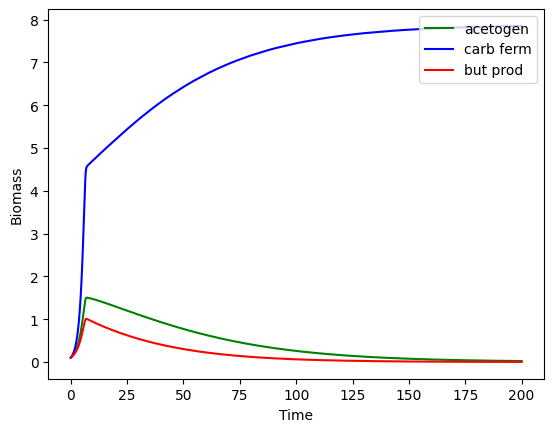

In [17]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[8], color='g', label='acetogen')
ax.plot(solution.t, solution.y[9], color='b', label='carb ferm')
ax.plot(solution.t, solution.y[10], color='r', label='but prod')
ax.set_ylabel('Biomass')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
#plt.savefig('/home/daniel_garza/plots/dFBA_biomass.png', dpi=300)
plt.show()

#### **Plot the results for metabolites**

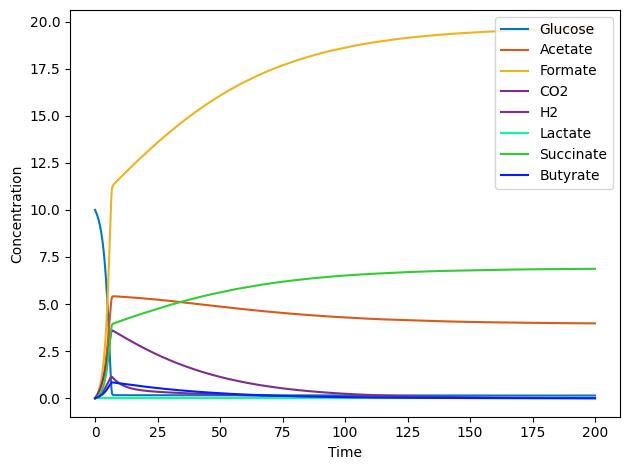

In [18]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[0], color='#0776c0', label='Glucose')

ax.plot(solution.t, solution.y[4], color='#db571a', label='Acetate')

ax.plot(solution.t, solution.y[1], color='#edb320', label='Formate')

ax.plot(solution.t, solution.y[2], color='#7e2c8d', label='CO2')
ax.plot(solution.t, solution.y[3], color='#7e2c8d', label='H2')

ax.plot(solution.t, solution.y[5], color='#00ff9f', label='Lactate')
ax.plot(solution.t, solution.y[6], color='#32CD32', label='Succinate')
ax.plot(solution.t, solution.y[7], color='#001eff', label='Butyrate')


ax.set_ylabel('Concentration')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('/home/daniel_garza/plots/dFBA_concentrations.png', dpi=300)
plt.show()